# Ch 1. Regression Models

In [1]:
import pystan
from matplotlib import pyplot as plt
import arviz as az
import numpy as np

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (8.0, 5.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15

## 1.1 Linear Regression

Mathematical notation of standard linear regression.

$$
y_n = \alpha + \beta x_n + \epsilon_n \quad \text{where} \quad \epsilon_n \sim N(0, \sigma) \\
y_n \sim N(\alpha + \beta X_n, \sigma)
$$

This is shown in Stan below.

```c
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    y ~ normal(alpha + beta * x, sigma);
}
```

Note that the model is vectorized such that each data point is not iterated over as shown below.
The vectorized version is not only easier to read, but runs faster, too.

```c
model {
    for (n in 1:N)
        y[n] ~ normal(alpha + beta * x[n], sigma)
}
```

This vectorization along with overloading the arithmetic operators allows for easy use of matrix in the models, too.

```c
data {
    int<lower=0> N;  // number of data points
    int<lower=0> K;  // number of predictors (columns)
    matrix[N, K] x;  // predictor matrix
    vector[N] y;     // outcome vector
}

parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;
}

model {
    y ~ normal(x * beta + alpha, sigma)
}
```

### Example

An example of a simple linear regression.
The Stan model is available in [stan-models/ch01_regression-models_linear-reg.stan](stan-models/ch01_regression-models_linear-reg.stan)

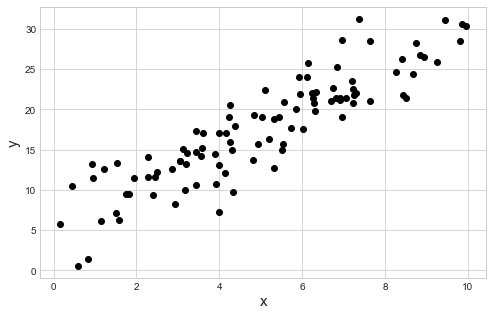

In [2]:
np.random.seed(123)

N = 100
alpha_real = 5.0
beta_real = 2.5
sigma_real = 3.0

x = np.random.uniform(0, 10, N)
y = alpha_real + beta_real * x + np.random.normal(0, sigma_real, N)

plt.plot(x, y, 'ko')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [3]:
lm_m1_data = {
    'N': N,
    'x': x,
    'y': y
}

lm_m1 = pystan.StanModel(file='stan-models/ch01_regression-models_linear-reg.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_811f32dcbac7f45107073d98cec5a743 NOW.


In [4]:
lm_m1_fit = lm_m1.sampling(data=lm_m1_data, iter=1000, chains=4)

/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3

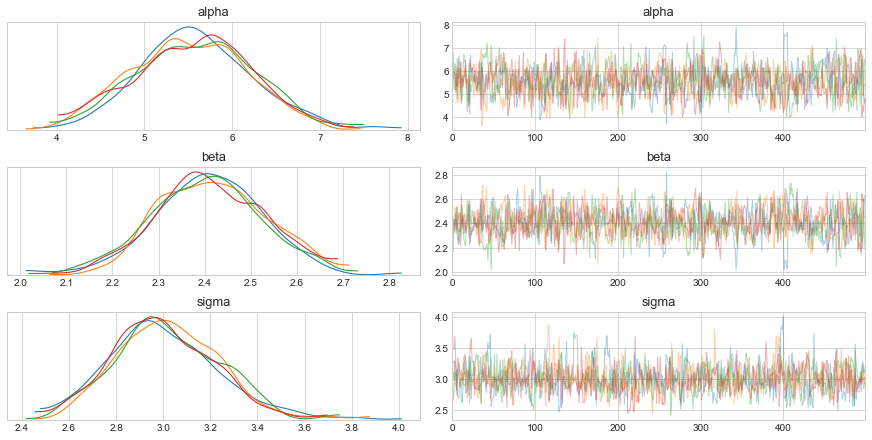

In [5]:
az_lm_m1_fit = az.from_pystan(lm_m1_fit, posterior_model=lm_m1_fit)
az.plot_trace(az_lm_m1_fit)
plt.show()

## 1.2 The QR Reparameterization

QR decomposition can be used to reparameterize $x \beta$ when there are more than one predictors $K$ and there are more data points $N$ than predcitors, $N \geq K$.
If these conditions are satisfied, then the reparamerterization is $x = QR$ where $Q$ is an orthogonal matrix and $R$ is an upper-triangular matrix.

This method is recommended for linear and generalized linear models whenever $K \gt 1$ and there are no informative priors on the location of $\beta$.

The functions `qr_Q()` and `qr_R()` implement the $QR$ decomposition.
In practice, it is recommended to use $x = Q^* R^*$ where $Q^* = Q \times \sqrt{n-1}$ and $R^* = \frac{R}{\sqrt{n-1}$ where $n$ is the number of data points.

The overall reparameterization is: $\eta = x \beta = QR \beta = Q^* R^* \beta$.
If we let $\theta = R^* \beta$ then $\eta = Q^* \theta$ and $\beta = R^{*-1} \theta$.

```c
data {
    int<lower=0> N;
    int<lower=0> K;
    matrix[N, K] x;
    vector[N] y;
}
transformed data {
    matrix[N, K] Q_ast;
    matrix[K, K] R_ast;
    matrix[K, K] R_ast_inverse;
    
    Q_ast = qr_Q(x)[, 1:K] * sqrt(N - 1);
    R_ast = qr_R(x)[1:K, ] / sqrt(N - 1);
    R_ast_inverse = inverse(R_ast);
}
parameters {
    real alpha;
    vector[k] theta;
    real<lower=0> sigma;
}
model {
    y ~ normal(Q_ast * theta + alpha, sigma);
}
generated quantities {
    vector[K] = beta;
    beta = R_ast_inverse * theta;
}
```

## 1.3 Priors for Coefficients and Scales

This topic is dicussed in other chapters.

## 1.4 Robust Noise Models

Robust regression can be accomidated by using a Student-*t* distribution for the noise of a linear model.
This is demonstrated below using $\nu$ as the degrees of freedom (a.k.a "shape") of the distribution.

```c
data {
    ...
    real<lower=0> nu;
}
...
model {
    y ~ student_t(nu, alpha + beta * x, sigma);
}
```

## 1.5 Logistic and Probit Regression

Generalized linear models with sigmoid-shaped link functions that map linear predictions $(-\infty, \infty)$ to probability values $(0, 1)$.

Below is an example of a logisitic regression model with one predictor and an intercept.

```c
data {
    int<lower=0> N;
    vector[N] x;
    int<lower=0, upper=1> y[N];
}
parameters {
    real alpha;
    real beta;
}
model {
    y ~ bernoulli_logit(alpha + beta * x);
}
```

Probit regression uses the cumulative normal distribution function.

$$
\Phi(x) = \int_{-\infty}^{x} N(y | 0,1) \text{ d}y 
$$

This is implemented in Stan as the `Phi()` function (or the faster approximation `Phi_approx()`).

```c
model {
    y ~ bernoulli(Phi(alpha + beta * x));
}
```

### Example

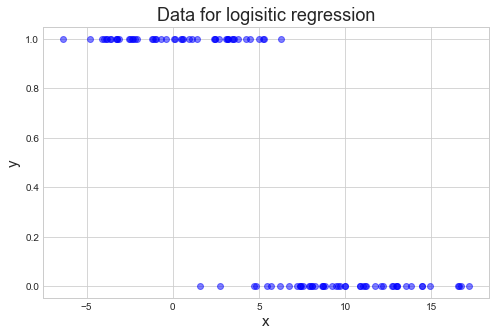

In [6]:
np.random.seed(123)

N = 100

alpha = 2.0

g1_mean = 10.0
g1_sigma = 3.0

g2_mean = 0.0
g2_sigma = 3.0

x1 = np.random.normal(g1_mean, g1_sigma, int(N / 2.0))
x2 = np.random.normal(g2_mean, g2_sigma, int(N / 2.0))
x = np.concatenate((x1, x2))

y = np.concatenate((np.repeat(0, N / 2), np.repeat(1, N / 2))).astype(np.int)

plt.plot(x, y, 'bo', alpha = 0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data for logisitic regression')
plt.show()

In [7]:
logreg_data = {
    'N': N,
    'x': x,
    'y': y
}

The Stan code is available in [stan-models/ch01_regression-models_logistic-reg.stan](stan-models/ch01_regression-models_logistic-reg.stan).

In [8]:
m_logreg = pystan.StanModel(file='stan-models/ch01_regression-models_logistic-reg.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f46cac6794bd18b9d014a889ac31276b NOW.


In [9]:
m_logreg_fit = m_logreg.sampling(data=logreg_data, iter=2000, chains=4)

/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/Caskroom/miniconda/base/envs/stan-user-guide-notes/lib/python3

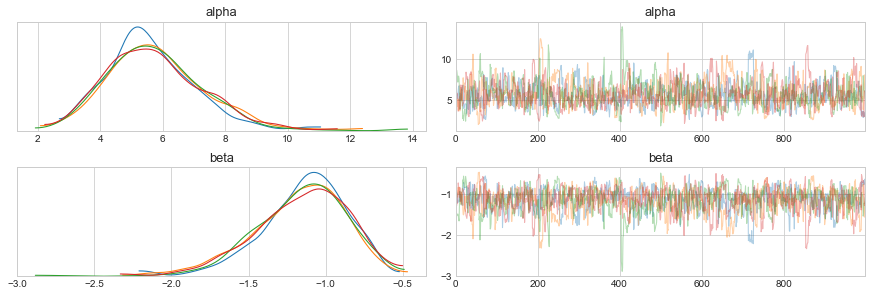

In [10]:
az_logreg_fit = az.from_pystan(m_logreg_fit, posterior_model=m_logreg)
az.plot_trace(az_logreg_fit)
plt.show()

In [11]:
az.summary(az_logreg_fit)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,5.746,1.530,3.045,8.546,0.059,0.044,666.0,602.0,725.0,651.0,1.01
beta,-1.158,0.296,-1.716,-0.656,0.012,0.009,633.0,517.0,697.0,674.0,1.01


In [12]:
m_logreg_fit

Inference for Stan model: anon_model_f46cac6794bd18b9d014a889ac31276b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   5.75    0.06   1.53   3.19   4.71   5.58   6.64   9.05    675   1.01
beta   -1.16    0.01    0.3  -1.82  -1.33  -1.12  -0.95  -0.67    653   1.01
lp__  -17.29    0.04   1.12 -20.28 -17.72 -16.95  -16.5 -16.21    625   1.01

Samples were drawn using NUTS at Wed Aug 19 08:33:14 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

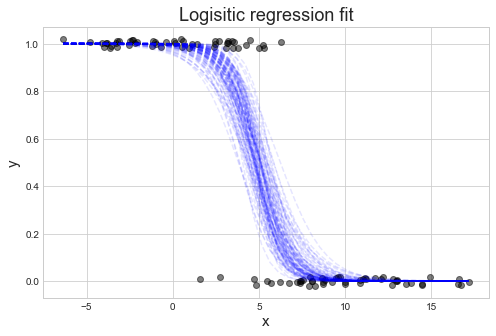

In [13]:
new_x = np.linspace(x.min(), x.max(), 50)

post_data = m_logreg_fit.extract(permuted=True, inc_warmup=False)

plt.plot(x, y + np.random.uniform(-0.02, 0.02, N), 'ko', alpha=0.5)

for i in range(0, 100):
    alpha = post_data['alpha'][i]
    beta = post_data['beta'][i]
    mu = alpha + beta * new_x
    new_y = 1 / (1 + np.exp(-mu))
    plt.plot(new_x, new_y, 'b--', alpha=0.1)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Logisitic regression fit')
plt.show()

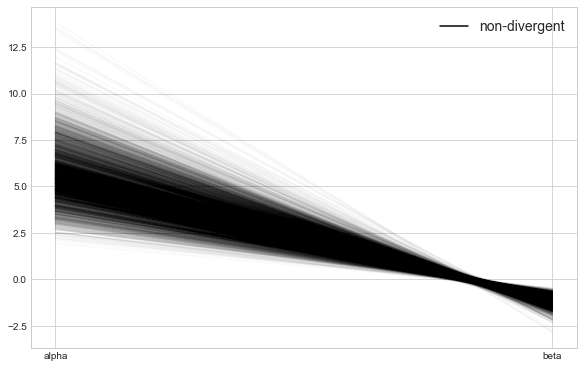

In [14]:
az.plot_parallel(az_logreg_fit)
plt.show()

## 1.6 Multi-Logit Regression

Multiple outcome forms of logisitic regression can be coded directly in Stan.

The following code is for when there are $K$ possible outcomes for output variable $y_n$ and $x_n$ is a $N \times D$ matrix of predictors.

```c
data {
    int<lower=2> K;              // number of outcome categories
    int<lower=0> N;              // number of data points
    int<lower=1> D;              // number of predictors
    int<lower=0, upper=K> y[N];  // outcomes
    matrix[N, D] x;              //predictors
}
parameters {
    matrix[D, K] beta;
}
model {
    matrix[N, K] x_beta = x * beta;
    to_vector(beta) ~ normal(0, 5);
    for (n in 1:N)
        y[n] ~ categorical_logit(x_beta[n]);
```

Currently, the categorical-logit distribution is not vectorized, the a for loop is necessary.

For reasons of model identifiability, it might be useful to code one of the outcome categories as 0.
There is more information on how this effects the model in the User Guide.

## 1.7 Parameterizing Centered Vectors

Common to define a parameter vector $\beta$ that is centered such that it sums to zero.
This is the case with categorical predictors that represent offsets from the intercept.

$$
\sum_{k=1}^{K} \beta_k = 0
$$

There is more information covered in the User Guide, though they do mention that setting the mean of the prior on $\beta$ as 0 (e.g. $\beta \sim N(0, \sigma)$)is considered "Soft Centering" because there is no guarantee that the actual values sum to 0.

## 1.8 Ordered Logistic and Probit Regression

*I will return to this when I cover it in* Doing Bayesian Data Analysis.

## 1.9 Hierarchical Logistic Regression

The data are grouped into $L$ distinct categories.
One approach would be to pool all of the data and estimate a common vector of regression coefficients $\beta$ (i.e. ignore the categories).
The other extreme would be to assign each level $l$ its own coefficient vector $\beta_l$ that is estimated separately from the others.
A hierarchical model is an intermediate solution where the degree of pooling is determined by the data and a prior on the amount of pooling.

Suppose each binary outcome $y_n \in \{0, 1\}$ has an associated level $ll_n \in \{1, \dots, L \}$ and an associated predictor vector $n_x \in \mathbb{R}^D$.
Each level $l$ gets its own coefficient vector $\beta_l \in \mathbb{R}^D$ that is drawn from a distribution with a prior and parameters estimated from the data.
These parameters estimate the variation across categories.

The following model encodes a hierarchical logisitic regression model with a hierarchical prior on the regression coefficients.

```c
data {
    int<lower=1> D;               // number of predictors
    int<lower=0> N;               // numbder of data points
    int<lower=1> L;               // number of categories
    int<lower=0, upper=1> y[N];   // outcomes
    int<lower=1, upper=L> ll[N];  // category assignments
    row_vector[D] x[N];           // an array of vectors for the predictor data
}
parameters {
    real mu[D];              // hierarchical prior mean on beta
    real<lower=0> sigma[D];  // hierarchical prior std. dev. of beta with implicit prior [0, infty)
    vector[D] beta[L];       // predictor coefficients
}
model {
    for (d in 1:D) {
        mu[d] ~ normal(0, 100);
        for (l in 1:L) 
            beta[l,d] ~ normal(mu[d], sigma[d]);
    }
    for (n in 1:N)
        y[n] ~ bernoulli(inv_logit(x[n] * beta[ll[n]]));
}
```

### Optimizing the model

Vectorizing the sampling statements leads to faster log probability and derivative evaluations because subcomputations can be shared across the vector. 
(For-loops are translated directly to C++, so they do not slow do computation.)

The for-loop for `D` can be vectorized resulting in the following.

```c
mu ~ normal(0, 100);
for (l in 1:L)
    beta[l] ~ normal(mu, sigma);
```

Since `beta` is an array of vectors, the expression `beta[l]` results in a vector.
This method, as opposed to declaring `beta` as a matrix, results in faster at accessing rows.

Another optimization is to replace `bernoulli(inv_logit(...))` with `bernoulli_logit(...)`.

```c
for (n in 1:N)
    y[n] ~ bernoulli_logit(x[n] * beta[ll[n]]));
```

Because array access and assignements are fast in Stan, the creation of `x_beta_ll` and then passing this to the likelihood function `bernoulli_logit()` is faster than the original formulation.
However, since it is more difficult to read, this modification should only be made after the model development and experimenting is complete.

```c
{
    vector[N] x_beta_ll;
    for (n in 1:N)
        x_beta_ll[n] = x[n] * beta[ll[n]];
    y ~ bernoulli_logit(x_beta_ll);
}
```

## 1.10 Hierarchical Priors

## 1.11 Item-Response Theory Models

## 1.12 Priors for Identifiability

To-do